In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import zuko
import matplotlib.pyplot as plt

from torch import Tensor
from torch.distributions import Distribution, Normal, Bernoulli, Independent
from torchvision.datasets import CIFAR10
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from tqdm import tqdm

import IPython

Files already downloaded and verified


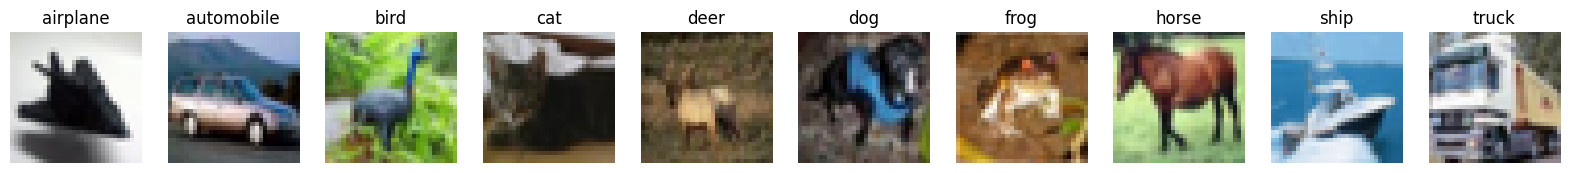

In [86]:
batch_size = 1024
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
    ]
)
trainset = CIFAR10(root="/datadrive/cbd/datasets/cifar", download=True, train=True, transform=transform)
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

def unnormalize(tensor, mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768]):
    """
    Undoes the normalization and returns the reconstructed images in the input tensor.
    """
    mean = torch.tensor(mean).reshape(1, -1, 1, 1)
    std = torch.tensor(std).reshape(1, -1, 1, 1)
    tensor = tensor * std + mean
    tensor = tensor.clamp(0, 1)  # Ensure the values are clipped to the [0, 1] range
    return tensor

# Plot example images
classes = 10
plt.subplots(1, classes, figsize=(20, 2))
for class_idx in range(classes):
    img_idx = 0
    images, label = trainset[img_idx]
    while label != class_idx:
        img_idx += 1
        images, label = trainset[img_idx]
    
    plt.subplot(1, classes, class_idx + 1)
    plt.imshow(to_pil_image(unnormalize(images.unsqueeze(0)).squeeze(0)))
    # plt.imshow(to_pil_image(images))
    plt.title(trainset.classes[label])
    plt.axis("off")

plt.show()

In [87]:
# Define the nominal dataset to include all classs except trucks
nominal_classes = list(range(9))
nominal_trainset = data.Subset(trainset, [i for i in range(len(trainset)) if trainset[i][1] in nominal_classes])

# Define the target dataset to include only trucks
target_trainset = data.Subset(trainset, [i for i in range(len(trainset)) if trainset[i][1] == 9])

In [94]:
# Sanity check; can we train a VAE on the nominal dataset?
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(64 * 4 * 4, 128)
        self.fc_logvar = nn.Linear(64 * 4 * 4, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        return self.fc_mu(x), self.fc_logvar(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(128, 64 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 64, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        return x

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

Epoch 1/100: loss = 1.50e+03, recon_loss = 1.44e+03, kl_loss = 5.24e+01: 100%|██████████| 49/49 [00:08<00:00,  5.98it/s]
Epoch 2/100: loss = 1.02e+03, recon_loss = 9.48e+02, kl_loss = 7.34e+01: 100%|██████████| 49/49 [00:08<00:00,  6.11it/s]
Epoch 3/100: loss = 8.85e+02, recon_loss = 7.98e+02, kl_loss = 8.61e+01: 100%|██████████| 49/49 [00:08<00:00,  6.11it/s]
Epoch 4/100: loss = 8.06e+02, recon_loss = 7.11e+02, kl_loss = 9.51e+01: 100%|██████████| 49/49 [00:08<00:00,  6.10it/s]
Epoch 5/100: loss = 7.76e+02, recon_loss = 6.80e+02, kl_loss = 9.61e+01: 100%|██████████| 49/49 [00:07<00:00,  6.14it/s]
Epoch 6/100: loss = 7.35e+02, recon_loss = 6.38e+02, kl_loss = 9.74e+01: 100%|██████████| 49/49 [00:07<00:00,  6.15it/s]
Epoch 7/100: loss = 6.21e+02, recon_loss = 5.21e+02, kl_loss = 1.00e+02: 100%|██████████| 49/49 [00:08<00:00,  6.05it/s]
Epoch 8/100: loss = 6.10e+02, recon_loss = 5.07e+02, kl_loss = 1.03e+02: 100%|██████████| 49/49 [00:07<00:00,  6.17it/s]
Epoch 9/100: loss = 6.07e+02, re

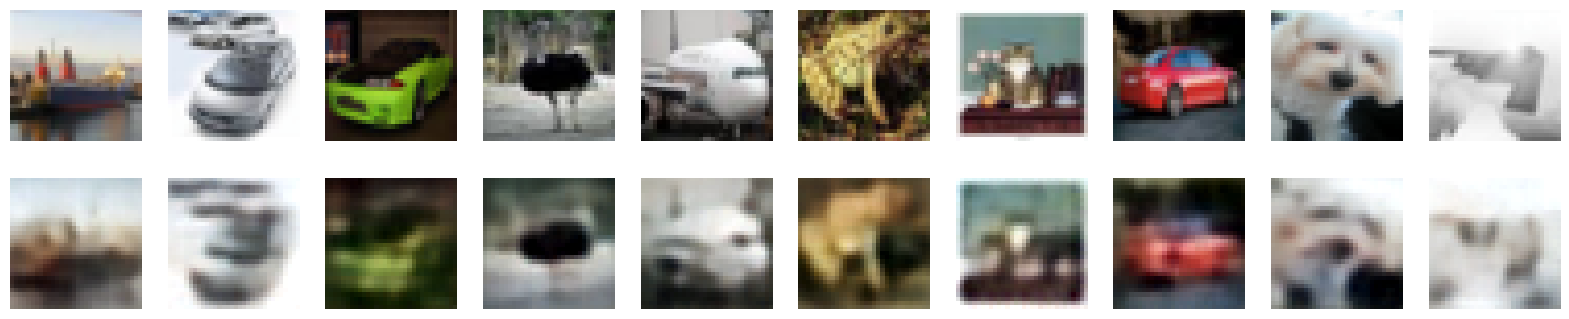

In [96]:
# Train the VAE
device = "cuda:0"
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 100
vae.train()
for epoch in range(num_epochs):
    pbar = tqdm(trainloader)
    for images, _ in pbar:
        optimizer.zero_grad()
        images = images.to(device)
        x_recon, mean, logvar = vae(images)
        loss, recon_loss, kl_loss = vae_loss(x_recon, images, mean, logvar)
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch + 1}/{num_epochs}: loss = {loss.detach().cpu().item() / batch_size:0.2e}, recon_loss = {recon_loss.detach().cpu().item() / batch_size:0.2e}, kl_loss = {kl_loss.detach().cpu().item() / batch_size:0.2e}")

# Visualize the reconstructions
vae.eval()
images, _ = next(iter(trainloader))
x_recon, _, _ = vae(images.to(device))
plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(to_pil_image(unnormalize(images[i].unsqueeze(0)).squeeze(0)))
    # plt.imshow(to_pil_image(images[i]))
    plt.axis("off")
    
    plt.subplot(2, 10, i + 11)
    plt.imshow(to_pil_image(unnormalize(x_recon[i].detach().unsqueeze(0).cpu()).squeeze(0)))
    # plt.imshow(to_pil_image(x_recon[i].detach().cpu()))
    plt.axis("off")

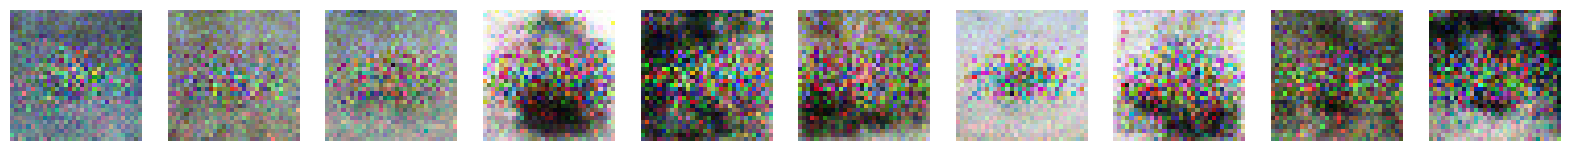

In [120]:
# # Define a dead-simple flow on the full dataset
# device = torch.device("cuda:0")
# flow = zuko.flows.NSF(
#     features=3 * 32 * 32, context=1, transforms=3, hidden_features=(256, 256)
# ).to(device)
# optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

# for epoch in range(num_epochs):
#     pbar = tqdm(trainloader)
#     for images, labels in pbar:
#         optimizer.zero_grad()
#         images = images.to(device)
#         labels = labels.to(device)
#         loss = -flow(labels.reshape(-1, 1)).log_prob(images.reshape(-1, 3 * 32 * 32)).mean()
#         loss.backward()
#         optimizer.step()

#         pbar.set_description(f"Epoch {epoch + 1}/{num_epochs}: loss = {loss.detach().cpu().item() / batch_size:0.2e}")

plt.subplots(1, 10, figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    sample_image = flow(torch.tensor([1.0], device=device)).sample().reshape(3, 32, 32).detach().cpu()
    plt.imshow(to_pil_image(unnormalize(sample_image).squeeze(0)))
    # plt.imshow(to_pil_image(x_recon[i].detach().cpu()))
    plt.axis("off")